# Neighborhood-Based Collaborative Filtering

## 🎯 Goal: Understand what is _cosine similarity_, and how and why to use it

### What is collaborative filtering?

In the context of e.g. recommendations engines, it is the process of infering the taste of one user, based on the knowledge of the tastes of other users.

### Types of collaborative filtering

* _neigborhood-based_ (also, _memory-based_):
    * **user-based**: looks for similarities in ratings between the target user and other users; _user-item matrix_
    * **item-based**: looks for similarities in items the target user has rated and other users have rated; _item-item matrix_
* _model-based_:
    * e.g. NMF, LDA, SVD

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 8)

In [2]:
df = pd.read_csv('./data/RFFMovieRatings.csv', index_col=0)

In [3]:
strip = lambda x: x.strip()
df.rename(columns=strip, index=strip, inplace=True)
df.columns.tolist(), df.index.tolist()

(['Inception',
  'Bladerunner 2049',
  'The Matrix',
  'Terminator 2',
  'City of God',
  'Batman The Dark Knight',
  'Titanic',
  'Castle in the Sky',
  'L. A. Confidental',
  'pulp fiction',
  'fight club',
  'Forrest Gump',
  'Frozen',
  'Rambo',
  'Terminator',
  'The naked gun',
  'A Christmas Carol (Animated)',
  'Transporter',
  'When Harry Met Sally',
  'Meet the Fockers',
  'Ex machina',
  'Call Me By Your Name',
  'Léon',
  'The Shawshank Redemption',
  'Disobedience',
  'The Wind that Shakes the Barley',
  'The Father',
  'No Country for Old Men'],
 ['Attila',
  'Basil',
  'Brunno',
  'Dietmar',
  'Jia',
  'Margit',
  'Max',
  'Maxim',
  'Pavel',
  'Philo'])

In [4]:
df = df.T

<AxesSubplot:>

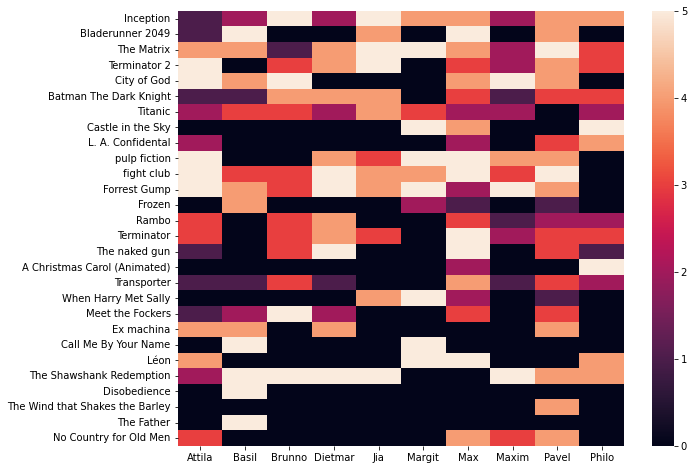

In [5]:
sns.heatmap(df.fillna(0))

### How do we measure similarity?

* Euclidean distance: $$ \sqrt{(x_1-x_2)^2 + (y_1-y_2)^2} $$
* Manhattan distance: $$ |x_1-x_2|+|y_1-y_2| $$
* Minkowsky distance: $$ \sqrt[\lambda]{|x_1-x_2|^\lambda + |y_1-y_2|^\lambda} $$
* Jaccard similarity (on sets): $$ \frac{|A \cap B|}{|A \cup B|} $$
* Cosine similarity

#### Cosine Similarity

Cosine similarity is a normalized dot product of two vectors (numerator is the dot product of the vectors, denominator is the product of the vector lengths). Geometrical interpretation is that it is an angle (more precisely a cosine of an angle) between the two vectors.

$$ cos(X, Y) = \frac{X \cdot Y}{\lVert X \rVert \lVert Y \rVert} = \frac{\sum x_i y_i}{\sqrt{\sum x_i^2}\sqrt{\sum y_i^2}} $$

In [6]:
def cosim(X, Y):
    num = np.nansum(X*Y) #np.dot(X, Y) 
    denom = np.sqrt(np.nansum(X*X)*np.nansum(Y*Y)) # np.sqrt(np.dot(X, X)) * np.sqrt(np.dot(Y, Y))
    return num/denom

In [7]:
cosim_table = []
for user1 in df.columns:
    row = []
    for user2 in df.columns:
        row.append(cosim(df[user1], df[user2]))
    cosim_table.append(row)

In [8]:
cosim_df = pd.DataFrame(cosim_table, index=df.columns, columns=df.columns).round(2)
cosim_df

,Attila,Basil,Brunno,Dietmar,Jia,Margit,Max,Maxim,Pavel,Philo
Attila,1.00,0.51,0.63,0.79,0.65,0.55,0.77,0.82,0.83,0.47
Basil,0.51,1.00,0.51,0.48,0.53,0.45,0.42,0.54,0.59,0.26
Brunno,0.63,0.51,1.00,0.75,0.65,0.30,0.66,0.72,0.73,0.54
Dietmar,0.79,0.48,0.75,1.00,0.74,0.44,0.67,0.71,0.80,0.50
Jia,0.65,0.53,0.65,0.74,1.00,0.59,0.63,0.70,0.72,0.53
Margit,0.55,0.45,0.30,0.44,0.59,1.00,0.60,0.48,0.44,0.43
Max,0.77,0.42,0.66,0.67,0.63,0.60,1.00,0.62,0.80,0.64
Maxim,0.82,0.54,0.72,0.71,0.70,0.48,0.62,1.00,0.76,0.39
Pavel,0.83,0.59,0.73,0.80,0.72,0.44,0.80,0.76,1.00,0.49
Philo,0.47,0.26,0.54,0.50,0.53,0.43,0.64,0.39,0.49,1.00


<AxesSubplot:>

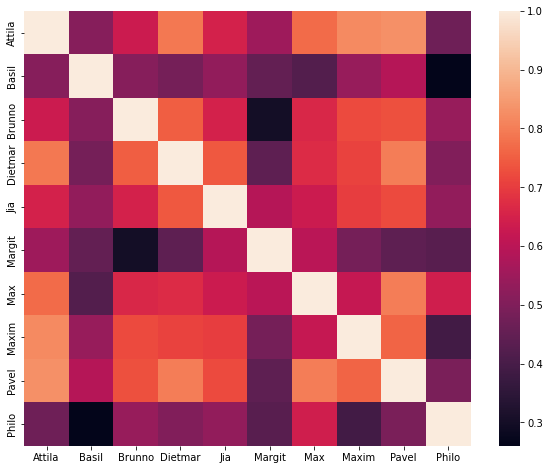

In [9]:
import seaborn as sns

sns.heatmap(cosim_df)

### Making predictions

What approach would you take now to recommending movies to people?

* Pick a target user
* Select the movies they haven't seen
* For each of the movies they haven't seen, get the list of users who have seen it
* Calculate the predicted rating as a cosine similarity weighted average of the ratings of the users who have seen it

In [10]:
df.loc['Disobedience']
# df.columns.tolist()

Attila     NaN
Basil      5.0
Brunno     NaN
Dietmar    NaN
Jia        NaN
Margit     NaN
Max        NaN
Maxim      NaN
Pavel      NaN
Philo      NaN
Name: Disobedience, dtype: float64

In [11]:
import math

# recomender parameters
min_cosim = 0.65
min_reference_users_cnt = 3

# target user
target_user = 'Maxim'

# movies they haven't seen
isna_user = df[target_user].isna()
unseen_movies = df[isna_user].index

# users that can be used as references
exclude_target_user = lambda x: x.index != target_user
reference_users = cosim_df[cosim_df[target_user] > min_cosim].loc[exclude_target_user].index.tolist()

# for each of the movies they haven't seen, get the list of users who have seen it
pred_movies = {}
for movie in unseen_movies:
    num = 0
    denom = 0

    movie_reference_users = df.loc[movie, reference_users].dropna()

    if len(movie_reference_users) < min_reference_users_cnt:
        continue

    for reference_user, rating in movie_reference_users.items():

        cosim = cosim_df.loc[target_user, reference_user]
        num += cosim * rating
        denom += cosim

    print('movie: %s; num: %s; denom: %s; movie_reference_users: %d' % (movie, num, denom, len(movie_reference_users)))

    pred_movies[movie] = num / denom if denom > 0 else 0
    
pred_movies
        

movie: Bladerunner 2049; num: 6.66; denom: 2.2800000000000002; movie_reference_users: 3
movie: The naked gun; num: 8.809999999999999; denom: 3.01; movie_reference_users: 4
movie: Meet the Fockers; num: 8.120000000000001; denom: 3.01; movie_reference_users: 4
movie: Ex machina; num: 9.16; denom: 2.29; movie_reference_users: 3


{'Bladerunner 2049': 2.921052631578947,
 'The naked gun': 2.926910299003322,
 'Meet the Fockers': 2.6976744186046515,
 'Ex machina': 4.0}

In [12]:
from neighborhood_based_cf import NeighborhoodBasedCF

In [13]:
df_test = pd.DataFrame({
    "Movie1": [None, 4, 1, 1, None],
    "Movie2": [3, 4, 1, None, 4],
    "Movie3": [1, 5, None, 2, 1],
    "Movie4": [2, None, None, 1, 1],
    "Movie5": [5, None, 5, 3, 1],
}, index=['user1', 'user2', 'user3', 'user4', 'user5'])
df_test

,Movie1,Movie2,Movie3,Movie4,Movie5
user1,NaN,3.0,1.0,2.0,5.0
user2,4.0,4.0,5.0,NaN,NaN
user3,1.0,1.0,NaN,NaN,5.0
user4,1.0,NaN,2.0,1.0,3.0
user5,NaN,4.0,1.0,1.0,1.0


In [14]:
NeighborhoodBasedCF._build_cosim_df(df_test.T)

,user1,user2,user3,user4,user5
user1,1.00,0.36,0.86,0.79,0.73
user2,0.36,1.00,0.20,0.48,0.64
user3,0.86,0.20,1.00,0.80,0.40
user4,0.79,0.48,0.80,1.00,0.36
user5,0.73,0.64,0.40,0.36,1.00


In [19]:
r = NeighborhoodBasedCF(df_test, 0.65, 2)
r.predict_ratings('user1')

{'Movie1': 1}